In [34]:
import numpy as np
import pyproj
import glob
import datetime
from netCDF4 import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
np.float = float

### load grid

In [35]:
def WGS84toEASE2(lon, lat):
    proj_EASE2 = pyproj.Proj("+proj=laea +lon_0=0 +lat_0=-90 +x_0=0 +y_0=0 +ellps=WGS84 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
    proj_WGS84 = pyproj.Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs ")
    x , y = pyproj.transform(proj_WGS84, proj_EASE2, lon, lat)
    return x, y

file='/Users/carmennab/cpom_server//home/gch/SS_budget_23/grids_S/Pathfinder_gs_SH.npz'
npzfile =  np.load(file)
lon = npzfile["lons"]
lat = npzfile["lats"]
grid_x, grid_y = WGS84toEASE2(lon, lat)

In [36]:
datapath = '/Users/carmennab/cpom_server/home/gch/SS_budget_23/2024-08-15/data_out_smoothed/'
files = sorted(glob.glob(datapath+'*.nc'))

In [37]:
figpath = '/Users/carmennab/Dropbox/michel_csao/figures/2015-2017/'

### plot actual values

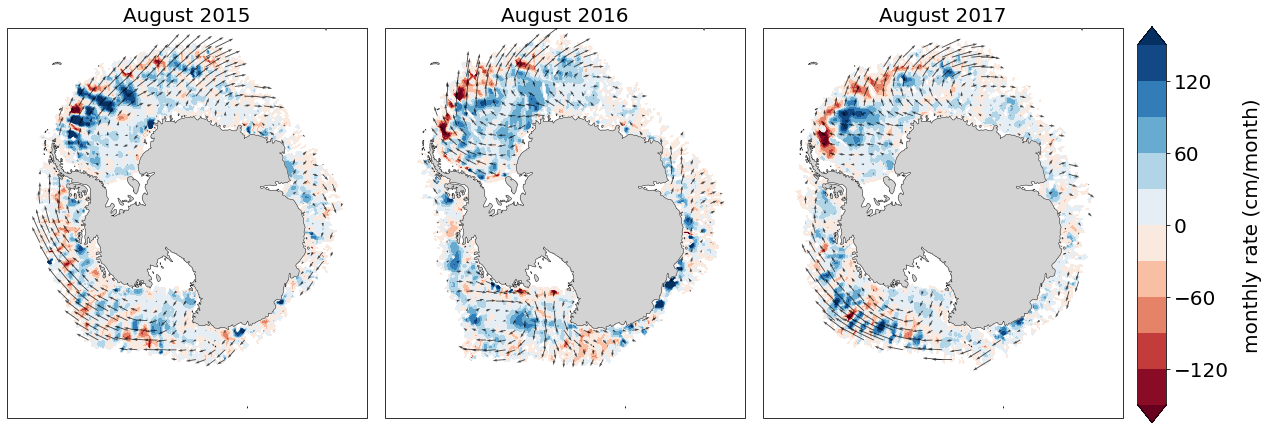

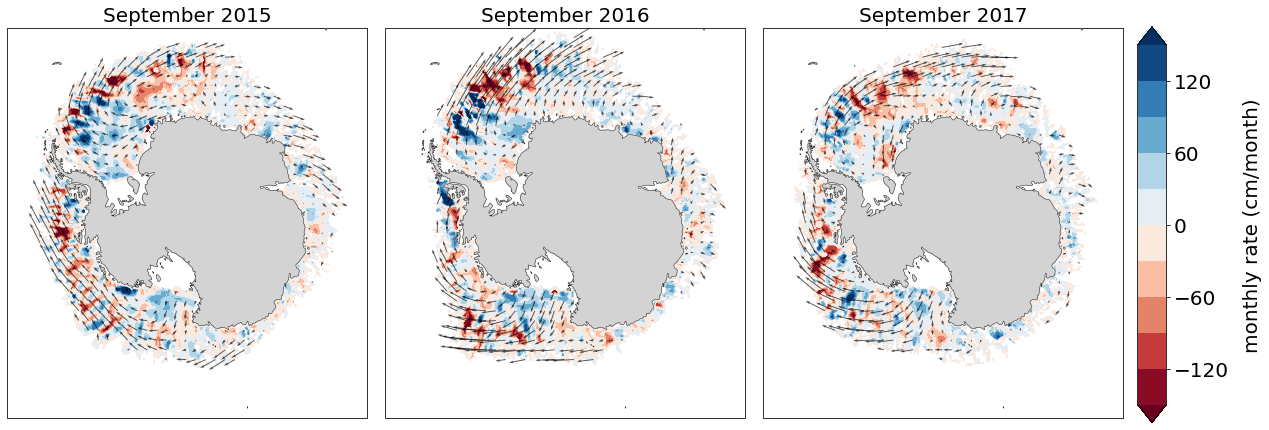

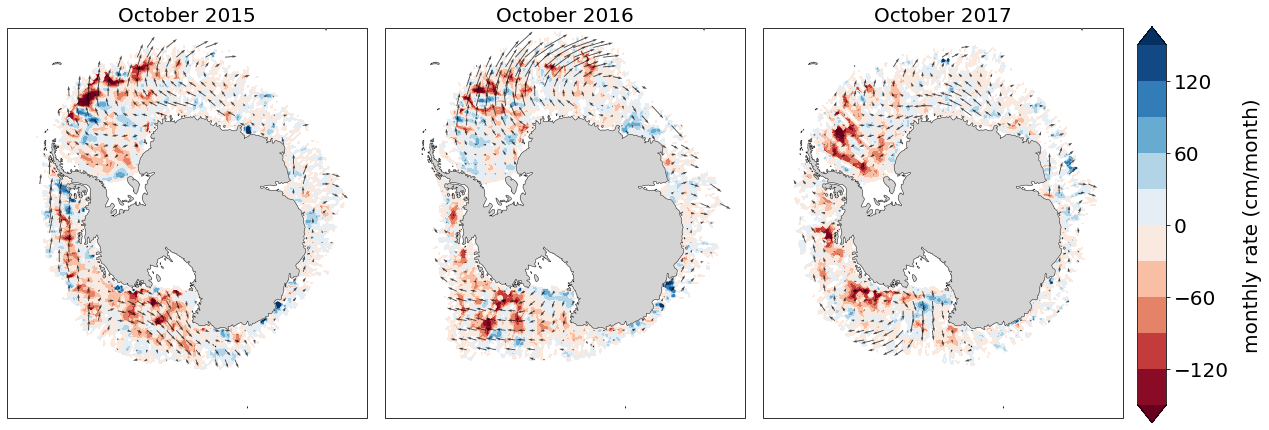

In [38]:
for m, month in zip([8,9,10],['August','September','October']):
    all_budgets = [] 

    for file in files:
        start_date_str = file.split('/')[9].split('_')[1].split('--')[0]
        start_date = datetime.datetime.strptime(start_date_str,"%Y%m%d").date()
        
        if ((start_date.year in [2015,2016,2017]) & (start_date.month == m)):

            data = Dataset(file)

            residual = np.array(data['residual']) * 86400
            ice_drift_x = np.array(data['ice_drift_x']) 
            ice_drift_y = np.array(data['ice_drift_y']) 

            b = {'year':start_date.year,'residual':residual,'ice_drift_x':ice_drift_x,'ice_drift_y':ice_drift_y}

            all_budgets.append(b)

    ### create dataframe of all budgets
    all_budgets = pd.DataFrame(all_budgets).sort_values(['year'])

    fig = plt.figure(figsize=(20,10))
    spec = gridspec.GridSpec(ncols=3, nrows=1, wspace=0.05,hspace=0.05)

    count = 0
    for count_y,year in enumerate(sorted(set(all_budgets['year']))):
        year_data = all_budgets[all_budgets['year']==year]
        drift_x = year_data['ice_drift_x'].iloc[0]
        drift_y = year_data['ice_drift_y'].iloc[0]
        residual = year_data['residual'].iloc[0]

        ax = fig.add_subplot(spec[count_y],projection=ccrs.SouthPolarStereo())
        ax.set_extent([-60, 180, -90, -55], ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE, zorder=100,linewidth=0.4)
        ax.add_feature(cfeature.LAND, zorder=99, color='lightgray', edgecolor='black')
        cmap = ax.contourf(grid_x,grid_y,residual*100,cmap='RdBu',levels=np.arange(-150,180,30),extend='both')
        ax.quiver(grid_x[::8, ::8], grid_y[::8, ::8], drift_x[::8, ::8],drift_y[::8, ::8], scale=2.7, 
                  color='black', alpha=0.7)
            

        ax.set_title(f'{month} {year}',fontsize=20)

        if count_y == 2: 
            cbar_ax = fig.add_axes([0.91, 0.225, 0.02, 0.55]) # x, y, width, height
            a = fig.colorbar(cmap, cax=cbar_ax,extend='both',) 
            a.set_label('monthly rate (cm/month)',size=20,labelpad=15)
            a.ax.tick_params(labelsize=20)

    plt.savefig(f'{figpath}residual_drift_{month}.jpg',bbox_inches = "tight", dpi = 800)
    plt.show()

### plot anomalies

In [39]:
all_budgets = [] 

for file in files:
    start_date_str = file.split('/')[9].split('_')[1].split('--')[0]
    start_date = datetime.datetime.strptime(start_date_str,"%Y%m%d").date()
    
    if start_date.month in [8,9,10]:

        data = Dataset(file)

        residual = np.array(data['residual']) * 86400
        ice_drift_x = np.array(data['ice_drift_x']) 
        ice_drift_y = np.array(data['ice_drift_y']) 

        b = {'year':start_date.year,'month':start_date.month,'residual':residual,'ice_drift_x':ice_drift_x,
             'ice_drift_y':ice_drift_y}

    all_budgets.append(b)
    
### create dataframe of all budgets
all_budgets = pd.DataFrame(all_budgets).sort_values(['month','year'])

/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_2372/474697731.py:4: RuntimeWarning: Mean of empty slice
  x_clim = np.nanmean(np.array([data for data in month_data['ice_drift_x']]),axis=0)
/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_2372/474697731.py:5: RuntimeWarning: Mean of empty slice
  y_clim = np.nanmean(np.array([data for data in month_data['ice_drift_y']]),axis=0)
/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_2372/474697731.py:6: RuntimeWarning: Mean of empty slice
  res_clim = np.nanmean(np.array([data for data in month_data['residual']]),axis=0)*100


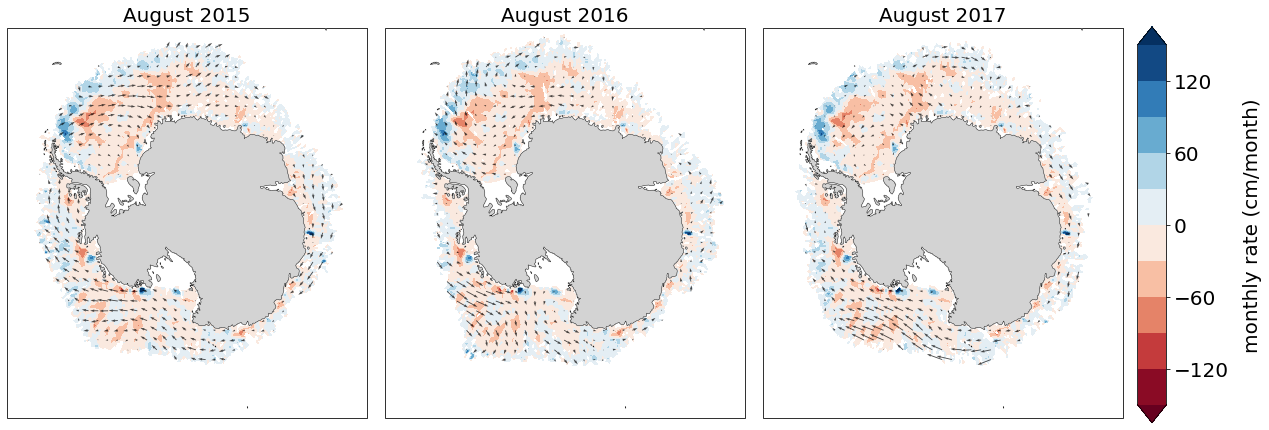

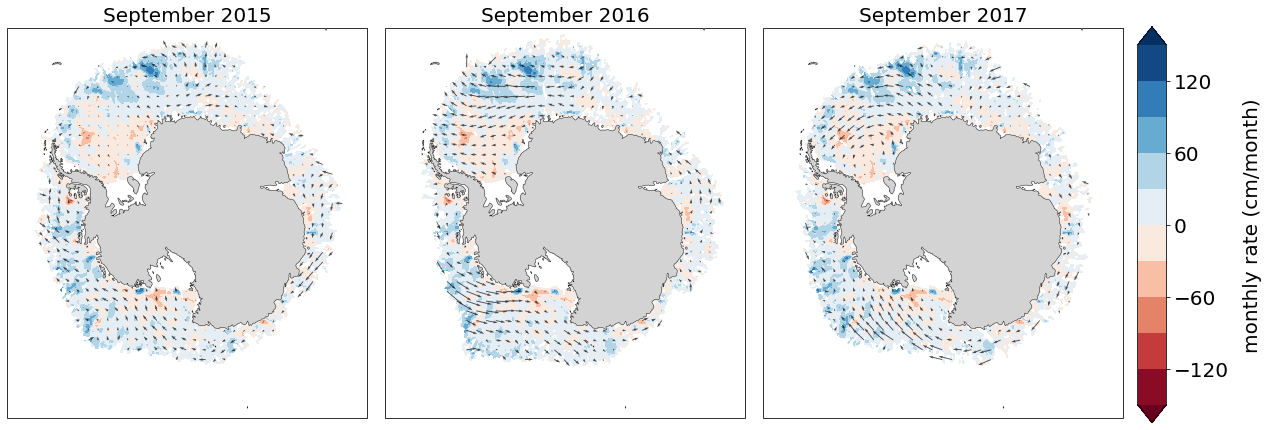

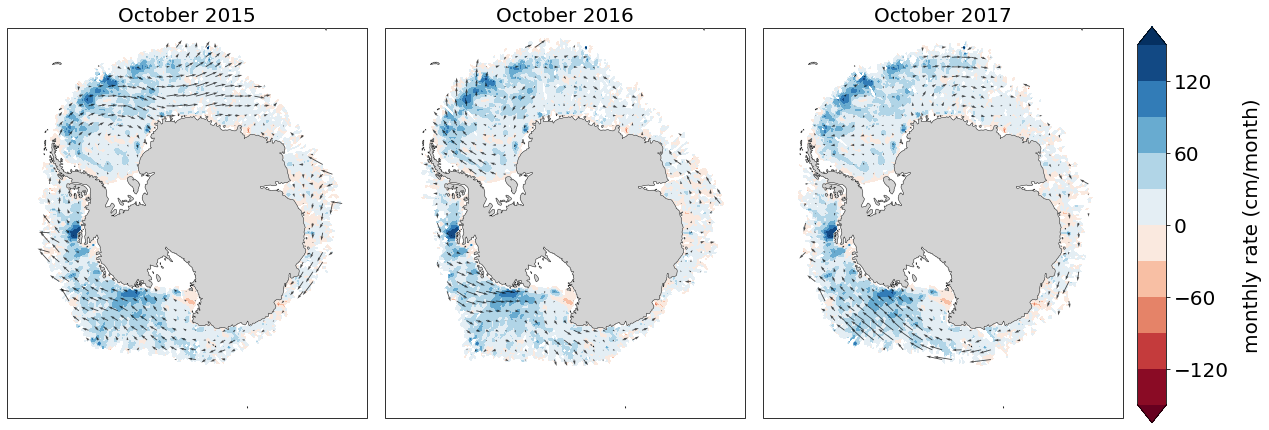

In [48]:
for m, month in zip([8,9,10],['August','September','October']):

    month_data = all_budgets[all_budgets['month']==m]
    x_clim = np.nanmean(np.array([data for data in month_data['ice_drift_x']]),axis=0)
    y_clim = np.nanmean(np.array([data for data in month_data['ice_drift_y']]),axis=0)
    res_clim = np.nanmean(np.array([data for data in month_data['residual']]),axis=0)*100

    fig = plt.figure(figsize=(20,10))
    spec = gridspec.GridSpec(ncols=3, nrows=1, wspace=0.05,hspace=0.05)

    count = 0
    for count_y,year in enumerate([2015,2016,2017]):
        year_data = all_budgets[all_budgets['year']==year]
        drift_x = year_data['ice_drift_x'].iloc[0] - x_clim
        drift_y = year_data['ice_drift_y'].iloc[0] - y_clim
        residual = year_data['residual'].iloc[0] - res_clim

        ax = fig.add_subplot(spec[count_y],projection=ccrs.SouthPolarStereo())
        ax.set_extent([-60, 180, -90, -55], ccrs.PlateCarree())
        ax.add_feature(cfeature.COASTLINE, zorder=100,linewidth=0.4)
        ax.add_feature(cfeature.LAND, zorder=99, color='lightgray', edgecolor='black')
        cmap = ax.contourf(grid_x,grid_y,residual,cmap='RdBu',levels=np.arange(-150,180,30),extend='both')
        ax.quiver(grid_x[::8, ::8], grid_y[::8, ::8], drift_x[::8, ::8],drift_y[::8, ::8], scale=2.7, 
                  color='black', alpha=0.7)
            
        ax.set_title(f'{month} {year}',fontsize=20)

        if count_y == 2: 
            cbar_ax = fig.add_axes([0.91, 0.225, 0.02, 0.55]) # x, y, width, height
            a = fig.colorbar(cmap, cax=cbar_ax,extend='both',) 
            a.set_label('monthly rate (cm/month)',size=20,labelpad=15)
            a.ax.tick_params(labelsize=20)

    plt.savefig(f'{figpath}residual_drift_{month}_anomaly.jpg',bbox_inches = "tight", dpi = 800)
    plt.show()